# 확률 네트워크기반 친환경 자동차 충전소(GVCS) 로케이션 인텔리전스(Location Intelligence) 대시보드

## 제안 배경

**친환경 자동차 생산에만 관심이 쏠려 사용자를 고려하지 못한 설치로 인한 잉여 충전소 발생**

- 민관 협력을 통해 충전 서비스 관련 사업이 꾸준히 증가함. 하지만 전국에 설치된 공공 급속충전기 총 2,896개(2021년 기준) 중 하루 1회 이하로 사용한 충전기가 1,164개로 전체의 40.1%를 차지하고 있다. 심지어 17개는 전혀 사용하지 않은 것으로 나타남.

- 이와 같은 충전소마다 이용 편차가 큰 이유는 전기차 보급 목표에 따라 구역별로  충전소를 나눠 설치했기 때문이라는 지적도 있다.

- 한국전기차충전협동조합은 앞으로 수요가 몰리는 거점을 중심을 중심으로 충전기 설치를 해야하 한다는 의견 주장함.

- 기존의 정부 중심으로 공급자 입장에서 설치하던 충전소를 친환경 자동차 차주를 고려해 이용자 중심으로 변화 설치가 필요하다는 지적도 있다.

즉, **꾸준히 증가하는 친환경 차량의 수요를 위해 저비용 고효율의 충전소 설치를 목표 한다.** 충전소 설치 사업자의 기대 수익 최적화를 위해 사용자 입장을 고려한 체계적이며 최적의 입지 선정 결과를 제시함.

## 사용 데이터

1. 충전소 위치 및 현황 정보
2. 급속충전기 보급 현황
3. LPG충전소 현황
4. 오존 월별 대기오염도
5. 아황산가스 월별 대기오염도
6. 이산화질소 월별 대기오염도
7. 미세먼지 월별 대기오염도
8. 행정구역별 인구수
9. 항만 현황
10. 지역별 전기차 등록대 수

In [608]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import networkx as nx
import numpy as np
from scipy.stats import norm
import plotly.express as px
import plotly.graph_objects as go

## 상위 요소 - 환경적 요인

대기오염도를 기반하여 확률 값을 계산한다.

### 오존 월별 대기오염도 데이터 불러오기

In [609]:
ozone_file_path = "C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\오존_월별_도시별_대기오염도.csv"
df_ozone = pd.read_csv(ozone_file_path, encoding='cp949')
df_ozone

,구분(1),구분(2),2021.02,2021.03,2021.04,2021.05,2021.06,2021.07
0,총계,소계,0.029,0.034,0.043,0.042,0.044,0.033
1,서울특별시,서울특별시,0.022,0.025,0.037,0.036,0.041,0.038
2,부산광역시,부산광역시,0.031,0.036,0.043,0.041,0.041,0.028
3,대구광역시,대구광역시,0.025,0.032,0.043,0.040,0.045,0.031
4,인천광역시,인천광역시,0.026,0.030,0.040,0.042,0.044,0.041
...,...,...,...,...,...,...,...,...
167,경상남도,합천,0.034,0.039,0.050,0.048,0.051,0.038**
168,경상남도,도평균,0.032,0.037,0.044,0.044,0.045,0.031
169,제주특별자치도,제주특별자치도,0.044,0.046,0.051,0.051,0.045,0.029
170,제주특별자치도,서귀포,0.045,0.048,0.054,0.052,0.046,0.028


In [610]:
df_ozone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   구분(1)    172 non-null    object
 1   구분(2)    172 non-null    object
 2   2021.02  172 non-null    object
 3   2021.03  172 non-null    object
 4   2021.04  172 non-null    object
 5   2021.05  172 non-null    object
 6   2021.06  172 non-null    object
 7   2021.07  172 non-null    object
dtypes: object(8)
memory usage: 10.9+ KB


In [611]:
ozen_col =  df_ozone.iloc[:,2:-1].columns.tolist()

In [612]:
df_ozone.drop(columns=ozen_col, inplace=True)

In [613]:
def advanced_replace(df, col, str, regex):
    '''
    DataFrame 특정 열의 특수문자 제거
    :param df: 대상 DataFrame
    :param col: column
    :param str: 제거할 특수 문자.
    :param regex: 적용할 정규표현식
    :return:
    '''
    df[col] = df[col].replace(str,0)
    df[col] = df[col].replace(to_replace=regex, value=r'', regex=True)
    return df

In [614]:
# 해당 컬럼 float 타입으로 변경
advanced_replace(df_ozone, df_ozone.iloc[:,2:].columns.tolist(), '-', r'[^0-9.0-9]')
df_ozone['2021.07'] = df_ozone['2021.07'].astype(float)
df_ozone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   구분(1)    172 non-null    object 
 1   구분(2)    172 non-null    object 
 2   2021.07  172 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.2+ KB


In [615]:
ddd = df_ozone.describe()

In [616]:
ddd

,2021.07
count,172.000000
mean,0.031924
std,0.005394
min,0.019000
25%,0.028000
50%,0.031000
75%,0.035000
max,0.059000


In [617]:
def show_norm(mean,std,min,max):
     '''
     정규분포 함수를 matplotlib을 통해 시각화
     mean: 평균값
     std: 표준편차
     min: 관측된 데이터의 최솟값
     max: 관측된 데이터의 최댓값
     '''
     
     # x값 설정(min에서 max까지 unit만큼씩 증가하는 x)
     x = np.linspace(min,max,100)
     # y값은 평균이 mean이고 표준편차가 std인 확률밀도함수
     fig = px.line(x=x,y=norm.pdf(x,loc=mean,scale=std))
     fig.show()

In [618]:
mean = df_ozone.iloc[:,2].mean()
std = df_ozone.iloc[:,2].std()
min = df_ozone.iloc[:,2].min()
max = df_ozone.iloc[:,2].max()
show_norm(mean,std,min,max)

### 부산광역시 오존의 누적확률 구하기

In [627]:
def cal_norm(mean,std,min,max,value):
     '''
     정규분포에서 value에 대한 누적확률 구하기
     mean: 평균값
     std: 표준편차
     min: 관측된 데이터의 최솟값
     max: 관측된 데이터의 최댓값
     value: 누적확률을 구하고자 하는 데이터의 측정값
     '''
   
     # x축 설정
     x = np.linspace(min,max,100)
     fig = go.Figure()
     # y축이 확률밀도로 구성된 정규분포 
     fig.add_trace(go.Scatter(x=x,y=norm.pdf(x,loc=mean,scale=std),mode='lines+markers'))
     # 확률 값을 구할 특정 구간의 범위 설정
     cum = np.linspace(min,value,100)
     # 구간 사이에 색을 채움
     fig.add_trace(go.Scatter(x=cum,y=norm.pdf(cum,mean,std), fill = 'tozeroy'))
     # value까지의 누적확률에서 min까지의 누적확률을 뺌
     pro = norm(mean,std).cdf(value)-norm(mean,std).cdf(min)
     fig.show()

     # 최종 누적확률 반환
     return pro

In [628]:
busan_oz = df_ozone[df_ozone['구분(2)']=='부산광역시'].loc[2,'2021.07']
ozone_pro = cal_norm(mean,std,min,max,busan_oz)
ozone_pro

0.22517026991990952

### 아황산가스 월별 데이터 불러오기

In [ ]:
so2_file_path = 'C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\아황산가스_월별_도시별_대기오염도.csv'
df_so2 = pd.read_csv(so2_file_path, encoding='cp949')
df_so2

,구분(1),구분(2),2021.02,2021.03,2021.04,2021.05,2021.06,2021.07
0,총계,소계,0.003,0.003,0.003,0.003,0.003,0.003
1,서울특별시,서울특별시,0.003,0.003,0.003,0.003,0.003,0.003
2,부산광역시,부산광역시,0.004,0.003,0.003,0.002,0.003,0.003
3,대구광역시,대구광역시,0.002,0.002,0.002,0.002,0.002,0.002
4,인천광역시,인천광역시,0.004,0.003,0.003,0.003,0.003,0.003
...,...,...,...,...,...,...,...,...
167,경상남도,합천,0.003,0.003,0.003,0.003,0.003,0.003**
168,경상남도,도평균,0.003,0.003,0.003,0.003,0.003,0.003
169,제주특별자치도,제주특별자치도,0.002,0.001,0.002,0.002,0.002,0.002
170,제주특별자치도,서귀포,0.001,0.001,0.001,0.001,0.001,0.001


In [ ]:
df_so2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   구분(1)    172 non-null    object
 1   구분(2)    172 non-null    object
 2   2021.02  172 non-null    object
 3   2021.03  172 non-null    object
 4   2021.04  172 non-null    object
 5   2021.05  172 non-null    object
 6   2021.06  172 non-null    object
 7   2021.07  172 non-null    object
dtypes: object(8)
memory usage: 10.9+ KB


In [ ]:
so2_col = df_so2.iloc[:,2:-1].columns.tolist()

In [ ]:
df_so2.drop(columns=so2_col, inplace=True)
df_so2

,구분(1),구분(2),2021.07
0,총계,소계,0.003
1,서울특별시,서울특별시,0.003
2,부산광역시,부산광역시,0.003
3,대구광역시,대구광역시,0.002
4,인천광역시,인천광역시,0.003
...,...,...,...
167,경상남도,합천,0.003**
168,경상남도,도평균,0.003
169,제주특별자치도,제주특별자치도,0.002
170,제주특별자치도,서귀포,0.001


In [ ]:
advanced_replace(df_so2,'2021.07','-',r'[^0-9.0-9]')
df_so2['2021.07'] = df_so2['2021.07'].astype(float)

In [ ]:
df_so2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   구분(1)    172 non-null    object 
 1   구분(2)    172 non-null    object 
 2   2021.07  172 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.2+ KB


In [ ]:
df_so2.describe()

,2021.07
count,172.000000
mean,0.002674
std,0.000764
min,0.001000
25%,0.002000
50%,0.003000
75%,0.003000
max,0.005000


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\3903135422.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df_so2.mean().loc['2021.07']
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\3903135422.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df_so2.std().loc['2021.07']


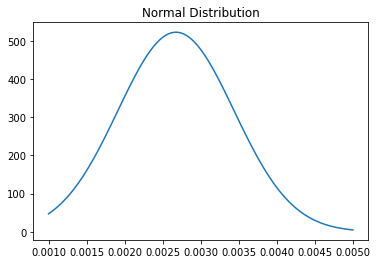

In [ ]:
mean = df_so2.mean().loc['2021.07']
std = df_so2.std().loc['2021.07']
min = df_so2.min().loc['2021.07']
max = df_so2.max().loc['2021.07']
show_norm(mean,std,min,max)

### 부산광역시 아황산가스의 누적확률 구하기

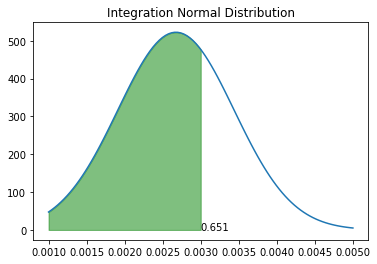

In [ ]:
busan_so2 = df_so2[df_so2['구분(2)']=='부산광역시'].loc[2,'2021.07']
so2_pro = cal_norm(mean,std,min,max,busan_so2)

### 이산화질소 월별 데이터 불러오기

In [ ]:
no2_file_path = 'C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\이산화질소_월별_도시별_대기오염도.csv'
df_no2 = pd.read_csv(no2_file_path, encoding='cp949')
df_no2

,구분(1),구분(2),2021.02,2021.03,2021.04,2021.05,2021.06,2021.07
0,총계,소계,0.019,0.019,0.014,0.012,0.011,0.010
1,서울특별시,서울특별시,0.030,0.032,0.022,0.019,0.018,0.016
2,부산광역시,부산광역시,0.018,0.017,0.015,0.014,0.014,0.010
3,대구광역시,대구광역시,0.022,0.018,0.013,0.012,0.010,0.009
4,인천광역시,인천광역시,0.024,0.028,0.021,0.017,0.017,0.014
...,...,...,...,...,...,...,...,...
167,경상남도,합천,0.014,0.011,0.010,0.009,0.010,0.009**
168,경상남도,도평균,0.016,0.014,0.013,0.011,0.012,0.009
169,제주특별자치도,제주특별자치도,0.011,0.011,0.010,0.010,0.009,0.006
170,제주특별자치도,서귀포,0.007,0.007,0.006,0.006,0.005,0.004


In [ ]:
no2_col = df_no2.iloc[:,2:-1].columns.tolist()

In [ ]:
df_no2.drop(columns=no2_col, inplace=True)

In [ ]:
advanced_replace(df_no2,'2021.07','-',r'[^0-9.0-9]')
df_no2['2021.07'] = df_no2['2021.07'].astype(float)

In [ ]:
df_no2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   구분(1)    172 non-null    object 
 1   구분(2)    172 non-null    object 
 2   2021.07  172 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.2+ KB


In [ ]:
df_no2.describe()

,2021.07
count,172.000000
mean,0.007610
std,0.003294
min,0.003000
25%,0.005000
50%,0.007000
75%,0.009250
max,0.019000


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\3824945817.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df_no2.mean().loc['2021.07']
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\3824945817.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df_no2.std().loc['2021.07']


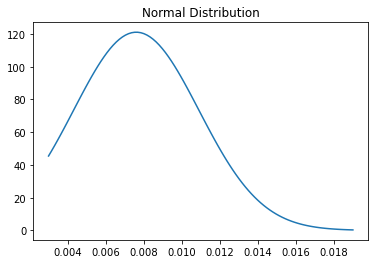

In [ ]:
mean = df_no2.mean().loc['2021.07']
std = df_no2.std().loc['2021.07']
min = df_no2.min().loc['2021.07']
max = df_no2.max().loc['2021.07']
show_norm(mean,std,min,max)

### 부산광역시 이산화질소 누적확률 구하기

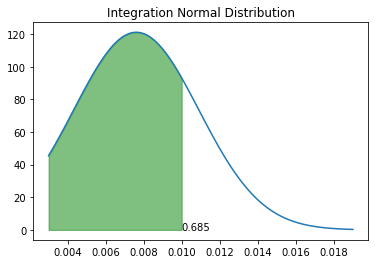

In [ ]:
busan_no2 = df_no2[df_no2['구분(2)']=='부산광역시'].loc[2,'2021.07']
no2_pro = cal_norm(mean,std,min,max,busan_no2)

### 일산화탄소 월별 데이터 불러오기

In [ ]:
co_file_path = 'C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\일산화탄소_월별_도시별_대기오염도.csv'
df_co = pd.read_csv(co_file_path, encoding='cp949')
df_co

,구분(1),구분(2),2021.02,2021.03,2021.04,2021.05,2021.06,2021.07
0,총계,소계,0.5,0.5,0.4,0.4,0.4,0.3
1,서울특별시,서울특별시,0.6,0.5,0.4,0.4,0.4,0.3
2,부산광역시,부산광역시,0.4,0.4,0.3,0.3,0.3,0.2
3,대구광역시,대구광역시,0.5,0.4,0.3,0.4,0.4,0.3
4,인천광역시,인천광역시,0.6,0.6,0.4,0.4,0.4,0.4
...,...,...,...,...,...,...,...,...
167,경상남도,합천,0.4,0.3,0.3,0.3,0.3,0.2**
168,경상남도,도평균,0.5,0.4,0.4,0.4,0.4,0.3
169,제주특별자치도,제주특별자치도,0.3,0.3,0.3,0.3,0.3,0.2
170,제주특별자치도,서귀포,0.3,0.3,0.3,0.3,0.2,0.2


In [ ]:
co_col = df_co.iloc[:,2:-1].columns.tolist()

In [ ]:
df_co.drop(columns=co_col, inplace=True)

In [ ]:
advanced_replace(df_co, '2021.07','-',r'[^0-9.0-9]')
df_co['2021.07'] = df_co['2021.07'].astype(float)

In [ ]:
df_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   구분(1)    172 non-null    object 
 1   구분(2)    172 non-null    object 
 2   2021.07  172 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.2+ KB


In [ ]:
df_co.describe()

,2021.07
count,172.000000
mean,0.328488
std,0.084825
min,0.100000
25%,0.300000
50%,0.300000
75%,0.400000
max,0.600000


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\1455709455.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df_co.mean().loc['2021.07']
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\1455709455.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df_co.std().loc['2021.07']


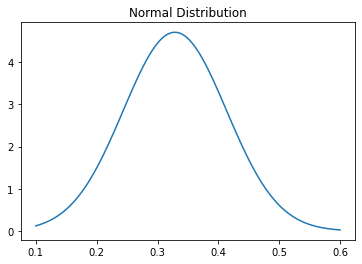

In [ ]:
mean = df_co.mean().loc['2021.07']
std = df_co.std().loc['2021.07']
min = df_co.min().loc['2021.07']
max = df_co.max().loc['2021.07']
show_norm(mean,std,min,max)

### 부산광역시 일산화탄소 누적확률 구하기

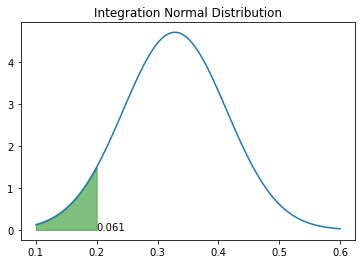

In [ ]:
busan_co = df_co[df_co['구분(2)']=='부산광역시'].loc[2,'2021.07']
co_pro = cal_norm(mean,std,min,max,busan_co)

### 미세먼지 월별 데이터 불러오기

In [ ]:
pm25_file_path = 'C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\미세먼지_PM2.5__월별_도시별_대기오염도.csv'
df_pm25 = pd.read_csv(pm25_file_path, encoding='cp949')
df_pm25

,구분(1),구분(2),2021.02,2021.03,2021.04,2021.05,2021.06,2021.07
0,총계,소계,25,27,17,19,19,12
1,서울특별시,서울특별시,29,32,19,20,19,15
2,부산광역시,부산광역시,21,21,15,16,15,9
3,대구광역시,대구광역시,24,23,17,18,20,10
4,인천광역시,인천광역시,28,33,19,20,23,19
...,...,...,...,...,...,...,...,...
167,경상남도,합천,18,17,14,15,18,11**
168,경상남도,도평균,19,19,15,15,16,12*
169,제주특별자치도,제주특별자치도,18,24,14,16,14,8
170,제주특별자치도,서귀포,16,23,14,16,12,8


In [ ]:
df_pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   구분(1)    172 non-null    object
 1   구분(2)    172 non-null    object
 2   2021.02  172 non-null    object
 3   2021.03  172 non-null    object
 4   2021.04  172 non-null    object
 5   2021.05  172 non-null    object
 6   2021.06  172 non-null    object
 7   2021.07  172 non-null    object
dtypes: object(8)
memory usage: 10.9+ KB


In [ ]:
pm25_col = df_pm25.iloc[:,2:-1].columns.tolist()

In [ ]:
df_pm25.drop(columns=pm25_col, inplace=True)

In [ ]:
advanced_replace(df_pm25, '2021.07','-',r'[^0-9.0-9]')
df_pm25['2021.07'] = df_pm25['2021.07'].astype(float)

In [ ]:
df_pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   구분(1)    172 non-null    object 
 1   구분(2)    172 non-null    object 
 2   2021.07  172 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.2+ KB


In [ ]:
df_pm25.describe()

,2021.07
count,172.000000
mean,11.558140
std,2.888188
min,0.000000
25%,10.000000
50%,11.000000
75%,13.000000
max,19.000000


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\2716057740.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df_pm25.mean().loc['2021.07']
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_23312\2716057740.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df_pm25.std().loc['2021.07']


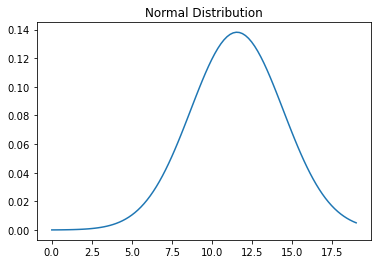

In [ ]:
mean = df_pm25.mean().loc['2021.07']
std = df_pm25.std().loc['2021.07']
min = df_pm25.min().loc['2021.07']
max = df_pm25.max().loc['2021.07']
show_norm(mean,std,min,max)

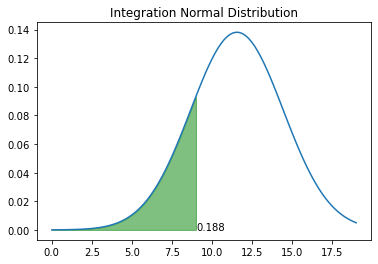

In [ ]:
busan_pm25 = df_pm25[df_pm25['구분(2)']=='부산광역시'].loc[2,'2021.07']
pm25_pro = cal_norm(mean,std,min,max,busan_pm25)

In [ ]:
pm10_file_path = 'C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\미세먼지_PM10__월별_도시별_대기오염도.csv'
df_pm10 = pd.read_csv(pm10_file_path, encoding='cp949')
df_pm10

,구분(1),구분(2),2021.02,2021.03,2021.04,2021.05,2021.06,2021.07
0,총계,소계,43,65,41,52,32,22
1,서울특별시,서울특별시,48,67,42,61,33,24
2,부산광역시,부산광역시,37,60,37,36,26,18
3,대구광역시,대구광역시,41,59,42,41,35,19
4,인천광역시,인천광역시,46,69,42,59,36,29
...,...,...,...,...,...,...,...,...
167,경상남도,합천,29,44,32,36,27,17**
168,경상남도,도평균,33,53,34,36,27,20
169,제주특별자치도,제주특별자치도,36,76,37,44,27,17
170,제주특별자치도,서귀포,33,68,35,40,23,21


In [ ]:
pm10_col = df_pm10.iloc[:,2:-1].columns.tolist()

In [ ]:
df_pm10.drop(columns=pm10_col, inplace=True)

In [ ]:
advanced_replace(df_pm10, '2021.07', '-', r'[^0-9.0-9]')
df_pm10['2021.07'] = df_pm10['2021.07'].astype(float)

In [ ]:
df_pm10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   구분(1)    172 non-null    object 
 1   구분(2)    172 non-null    object 
 2   2021.07  172 non-null    float64
dtypes: float64(1), object(2)
memory usage: 4.2+ KB


In [ ]:
df_pm10.describe()

,2021.07
count,172.000000
mean,20.750000
std,4.725352
min,0.000000
25%,18.000000
50%,20.000000
75%,23.000000
max,36.000000


## 상위 요소 - 사회적 요인

### 행정구역 인구 데이터 불러오기

In [ ]:
people_file_path = 'C:\\Users\\SAMSUNG\\Desktop\\Green-Car-Charging-Station-Site-Selection\\Data\\행정구역_시군구_별__성별_인구수.csv'
df_people = pd.read_csv(people_file_path, encoding='cp949', header=1)
df_people

,행정구역(시군구)별,총인구수 (명)
0,전국,51592660
1,서울특별시,9500480
2,종로구,144005
3,중구,122087
4,용산구,222009
...,...,...
287,거창군,60756
288,합천군,42613
289,제주특별자치도,677413
290,제주시,493076


In [ ]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   행정구역(시군구)별  292 non-null    object
 1   총인구수 (명)    292 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ KB


In [ ]:
df_people.describe()

,총인구수 (명)
count,2.920000e+02
mean,5.614314e+05
std,3.176068e+06
min,0.000000e+00
25%,5.282050e+04
50%,1.935545e+05
75%,3.709285e+05
max,5.159266e+07
